# Projet Optimisation - Partie 2
---

## Imports

In [2]:
import sys
import json # To store solutions
import numpy as np
np.set_printoptions(threshold=sys.maxsize) # To print more elements of an array in terminal
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# For modelising more complex problems
import cvxpy as cp

## Datas

In [195]:
# Loads dataframe
sites_df = pd.read_csv('Data-partie-2/Sites.csv')
offshore_df = pd.read_csv('Data-partie-2/Rendements_offshore.csv', header=None).to_numpy()
onshore_df = pd.read_csv('Data-partie-2/Rendements_onshore.csv', header=None).to_numpy()

# Get index of onshore and offshore sites and convert to numpy array
offshore_idx = sites_df[sites_df['capacite offshore'] == 'Oui']['index site'].to_numpy(dtype=int)
onshore_idx = sites_df[sites_df['capacite offshore'] == 'Non']['index site'].to_numpy(dtype=int)

# Get number of sites (n) and number of hours in a year (m)
n = sites_df.shape[0]
m = offshore_df.shape[1]

# Get max capacity of offshore and onshore sites
max_capacity = np.zeros(n)
max_capacity[offshore_idx] = sites_df[sites_df['capacite offshore'] == 'Oui']['capacites'].to_numpy(dtype=float)
max_capacity[onshore_idx] = sites_df[sites_df['capacite offshore'] == 'Non']['capacites'].to_numpy(dtype=float)

# Filter offshore and onshore dataframes
offshore_df = offshore_df[offshore_idx, :]
onshore_df = onshore_df[onshore_idx, :]
rendements_on_off = np.zeros((n, m)) # Matrix that contains all the rendements of onshore and offshore sites at the correct indices
rendements_on_off[offshore_idx, :] = offshore_df
rendements_on_off[onshore_idx, :] = onshore_df
rendements_on_off_3 = np.zeros((n,m//3))
for k in range(rendements_on_off.shape[0]): # Regroup by 3 hours
    rendements_on_off_3[k] = np.sum(rendements_on_off[k].reshape(-1,3), axis = 1)


# Loads consumption and hydro production
consumptions = np.sum(pd.read_csv('Data-partie-2/Consommations.csv', header=None).to_numpy(), axis = 0)
consumptions_3 = np.sum(consumptions.reshape(-1,3),axis = 1) # Regroup by 3 hours
hydro_productions = np.sum(pd.read_csv('Data-partie-2/Apports-hydro.csv', header=None).to_numpy(), axis = 0) 
hydro_productions_3 = np.sum(hydro_productions.reshape(-1,3),axis = 1) # Regroup by 3 hours

# Costs
onshore_install_cost = 168903 # [euro/MWh/year]
offshore_install_cost = 300336 # [euro/MWh/year]

gaz_install_cost = 94956 # [euro/MW/year]
gaz_production_cost = 65 # [euro/MWh]

# Country max stock per country [MWh]
max_stock = np.sum(np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6]))

# Max turbine and pump power per country [MW] 
max_turbine_power = np.sum(np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101]))*3
max_pump_power = np.sum(np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ]))*3

# Turbine efficiency (eta)
turbine_efficiency = 0.85

m = 2920 # Number of periods of 3 hours

## Question 4B
# Variables de décision
$$
\begin{align*} 
c_i = \text{Capacité éolienne installée sur le site i} \quad \forall i \in \{0, \ldots, 641 \} \implies c \in \mathbb{R}^{642} \\
t_j = \text{Puissance de turbinage à la période j} \quad \forall j \in \{0, \ldots, 2919\} \implies t \in \mathbb{R}^{2920}\\
p_j = \text{Puissance de pompage à la période j} \quad \forall j \in \{0, \ldots, 2919 \} \implies p \in \mathbb{R}^{2920}
\end{align*}
$$
# Problème à résoudre
$$
\begin{align*}
\min_{c, t, p} \sum_{offshore} c_i*300336 + \sum_{onshore} c_i * 168903 \\
\text{tel que} \\
\text{(Capacité éolienne entre 0 et son max)} \quad &0 \leq c_i \leq c_i^{max}  \quad \forall i \in \{0, \ldots, 641 \} \\
\text{(Le besoin de consommation est satisfait)} \quad &\sum_{i = 0}^{641} c_i e_i(j) + 0.85*t_j - p_j \geq cons_j \quad \forall j \in \{0, \ldots, 2919\} \\
\text{(Physique du bassin, de base à 0.5 de capacité tot au début de la première période)} \quad & 0 \leq \frac{max\_stock}{2} + \sum_{i = 0}^{j} \left(p_i - t_i + a_i \right) \leq max\_stock \quad \forall j \in \{0, \ldots, 2918\} \\
\text{(Contrainte de bilan nul du bassin)} \quad &\sum_{i = 0}^{2919} p_i - t_i + a_i = 0 \\
\text{(Contrainte de turbinage)} \quad &0 \leq \eta \cdot t_j \leq max\_turbinage \quad \forall j \in \{0, \ldots, 2919\} \\
\text{(Contrainte de pompage)} \quad &0 \leq p_j \leq max\_pompage \quad \forall j \in \{0, \ldots, 2919\}

\end{align*}
$$

In [196]:
# Variable vectors
c = cp.Variable(n)
t = cp.Variable(m)
p = cp.Variable(m)

# Objective function
costs = np.zeros(n)
costs[onshore_idx] = onshore_install_cost
costs[offshore_idx] = offshore_install_cost
f = cp.Minimize(costs.T@c)

constraints = [
    c >= 0,
    c <= max_capacity,
    c@rendements_on_off_3[:, 0:m] + 0.85*t - p >= consumptions_3[0:m],
    np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] <= 0.5*max_stock, #Condition plus facile pour les valeurs du dual, mais forcément équivalente
    np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] >= -0.5*max_stock, #Condition plus facile pour les valeurs du dual, mais forcément équivalente
    np.ones(m)@p - np.ones(m)@t + np.ones(m)@hydro_productions_3[0:m] == 0,
    p >= 0,
    p <= max_pump_power,
    0.85*t >= 0,
    0.85*t <= max_turbine_power
]
problem = cp.Problem(f, constraints)

problem.solve(solver=cp.SCIPY, verbose=True)


                                     CVXPY                                     
                                     v1.5.0                                    
(CVXPY) May 14 03:18:06 PM: Your problem has 6482 variables, 21723 constraints, and 0 parameters.
(CVXPY) May 14 03:18:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 14 03:18:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 14 03:18:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 14 03:18:06 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 14 03:18:06 PM: Compiling problem (target solver=SCIPY

150961169167.04733

# Temps d'exécution : 36.5 secondes (Solver : SCIPY, Valeur objectif : 150961169167.04733)

In [197]:
# Dual values of the constraints (Each row corresponds to a constraint and can be a float or an array)
dual_values = []
for constraint in problem.constraints:
    if type(constraint.dual_value) == float:
        dual_values.append(constraint.dual_value)
    else:
        dual_values.append(constraint.dual_value.tolist())

# Save the solution
dic = {
    'optimum': problem.value,
    'c': c.value.tolist(),
    't': t.value.tolist(),
    'p': p.value.tolist(),
    'dual_values': dual_values
}

json_object = json.dumps(dic, indent = 4)

with open('solutions/sol4B_All.json', 'w') as f:
    f.write(json_object)

In [198]:
solc = np.array(c.value)

In [199]:
soltp = np.stack((t.value, p.value))

In [200]:
np.save("solutions/sol4B_C.npy", solc)
np.save("solutions/sol4B_TP.npy", soltp)

In [201]:
sols = json.load(open('solutions/sol4B_All.json'))
CoutTotal = sols["optimum"]
CoutTotal/ np.sum(consumptions_3) #€/MWh

58.282183248477416

In [202]:
Turbinage = np.load("solutions/sol4B_TP.npy")[0]
Pompage = np.load("solutions/sol4B_TP.npy")[1]

In [203]:
from matplotlib.ticker import MaxNLocator

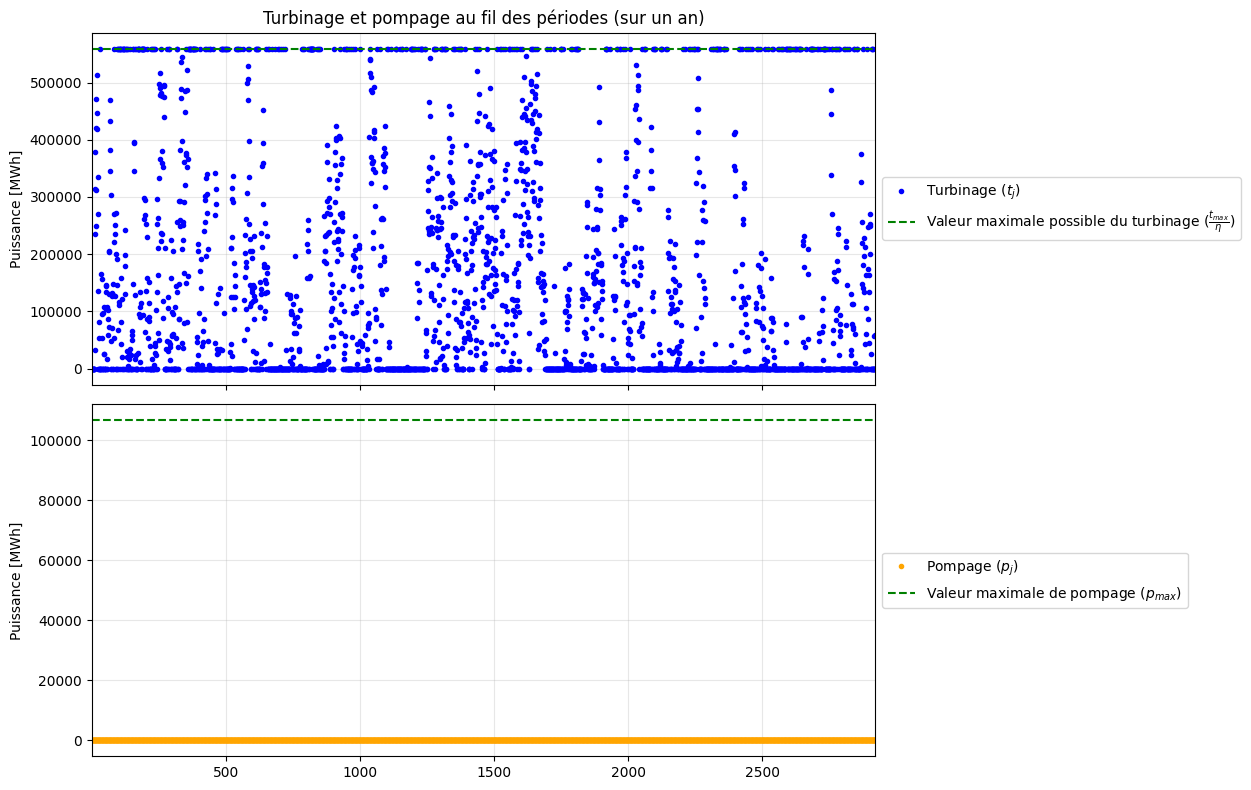

In [204]:
t = np.arange(1, m+1)

# Créer la figure et les axes pour les trois graphiques
fig, axs = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

# Graphique pour Turbinage
axs[0].set_title('Turbinage et pompage au fil des périodes (sur un an)')
axs[0].plot(t, Turbinage, ".", label='Turbinage ($t_j$)', color='blue')
axs[0].set_ylabel('Puissance [MWh]')
axs[0].set_xlim(1, m)
axs[0].grid(alpha=0.3)
axs[0].axhline(y=max_turbine_power/0.85, color='g', linestyle='--', label='Valeur maximale possible du turbinage ($\\frac{t_{max}}{\\eta}$)')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Graphique pour Pompage
axs[1].plot(t, Pompage, ".", label='Pompage ($p_j$)', color='orange')
axs[0].set_xlim(1, m)
axs[1].set_ylabel('Puissance [MWh]')
axs[1].grid(alpha=0.3)
axs[1].axhline(y=max_pump_power, color='g', linestyle='--', label='Valeur maximale de pompage ($p_{max}$)')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Ajuster le placement des légendes
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.savefig('rapport/GraphesP2/Turbinage_pompage_Q4.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

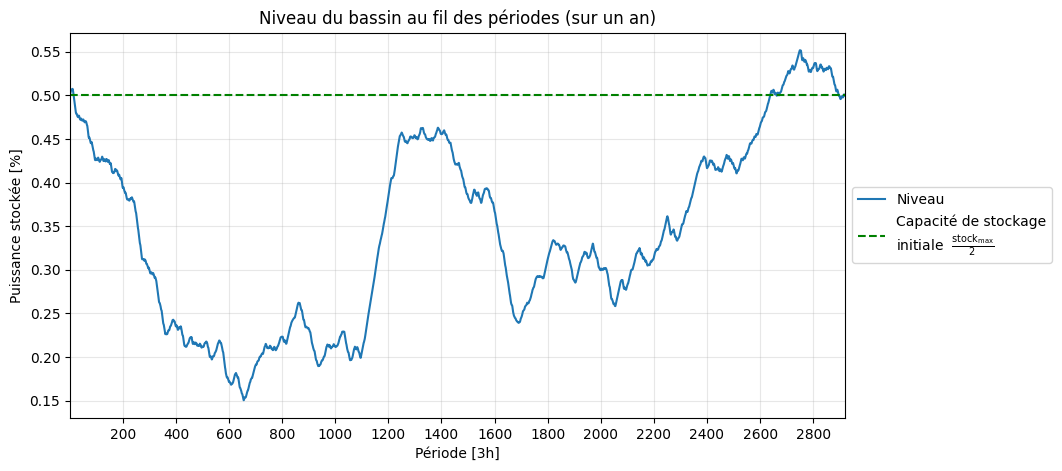

In [235]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Niveau du bassin au fil des périodes (sur un an)')
plt.plot(t, (max_stock/2 + np.tri(2920)@Pompage - np.tri(2920)@Turbinage + np.tri(2920)@hydro_productions_3)/max_stock, label='Niveau')
plt.xlabel('Période [3h]')
plt.ylabel('Puissance stockée [%]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.axhline(y=0.5, color='g', linestyle='--', label='Capacité de stockage\n'  + r"initiale  $\frac{\mathrm{stock}_\mathrm{max}}{2}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Niveau_Bassin_Q4.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [206]:
ChoixEolien = np.load("solutions/sol4B_C.npy")

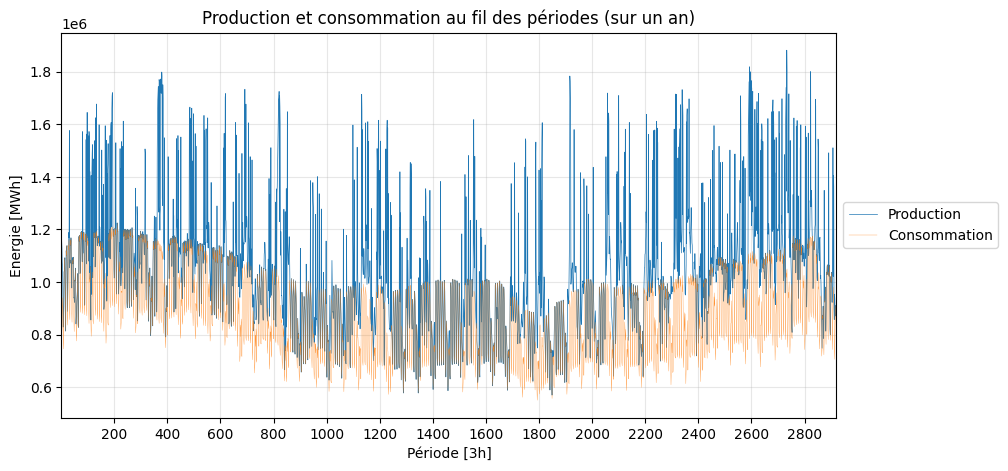

In [207]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Production et consommation au fil des périodes (sur un an)')
plt.plot(ChoixEolien@rendements_on_off_3 + 0.85*Turbinage - Pompage, label='Production', linewidth = 0.5)
plt.plot(consumptions_3, label='Consommation', linewidth = 0.2)
plt.xlabel('Période [3h]')
plt.ylabel('Energie [MWh]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Prod_Cons_Q4.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

## Question 4C

Changement du coût en ajoutant un MWh de stockage

In [3]:
# np.transpose(constraints[3].dual_value)@(0.5*-1*np.ones(2919))  + np.transpose(constraints[4].dual_value)@(0.5*-1*np.ones(2919)) #0
sol = json.load(open('solutions/sol4B_All.json'))
dual_values = sol['dual_values']

print(2*np.sum(np.array(dual_values[3])) - 2*np.sum(np.array(dual_values[4]))) #0

0.0


Changement du coût en ajoutant un MW de pompage

In [5]:
print(np.sum(np.array(dual_values[-3]))) #0
print(dual_values[-3])

0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Changement du coût en ajoutant un MW de turbinage

In [210]:
np.transpose(constraints[-1].dual_value)@(-1*3*np.ones(2920)) #-1583760.7871597356

-1583760.7871597356

## Question 5

Le problème reste le même qu'à la question 4, sauf que la variable de décision $c_i$ devient entière et prend les valeurs 0, 1 et 2, il faut aussi se resteindre à 1000 périodes.

In [211]:
m = 1000

In [212]:
# Variable vectors
c = cp.Variable(n, integer = True)
t = cp.Variable(m)
p = cp.Variable(m)

# Objective function
costs = np.zeros(n)
costs[onshore_idx] = onshore_install_cost
costs[offshore_idx] = offshore_install_cost
f = cp.Minimize(costs.T@(0.5*cp.multiply(c, max_capacity)))

constraints = [
    (0.5*cp.multiply(c, max_capacity))@rendements_on_off_3[:, 0:m] + 0.85*t - p >= consumptions_3[0:m],
    0.5*max_stock + np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] <= max_stock,
    0.5*max_stock + np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] >= 0,
    np.ones(m)@p - np.ones(m)@t + np.ones(m)@hydro_productions_3[0:m] == 0,
    c >= 0,
    c <= 2,
    p >= 0,
    p <= max_pump_power,
    0.85*t >= 0,
    0.85*t <= max_turbine_power,
]
problem = cp.Problem(f, constraints)

problem.solve(solver=cp.SCIPY, verbose=True)
#Coût total

                                     CVXPY                                     
                                     v1.5.0                                    
(CVXPY) May 14 03:18:44 PM: Your problem has 2642 variables, 8283 constraints, and 0 parameters.
(CVXPY) May 14 03:18:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 14 03:18:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 14 03:18:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 14 03:18:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 14 03:18:44 PM: Compiling problem (target solver=SCIPY)

125935889457.8857

# Temps d'exécution : 46 minutes et 10.5 secondes

In [213]:
soltp = np.stack((t.value, p.value))
np.save("solutions/sol5_C.npy", c.value)
np.save("solutions/sol5_TP.npy", soltp)

In [214]:
# Save the solution
dic = {
    'optimum': problem.value,
    'c': c.value.tolist(),
    't': t.value.tolist(),
    'p': p.value.tolist(),
}

json_object = json.dumps(dic, indent = 4)

with open('solutions/sol5_All.json', 'w') as f:
    f.write(json_object)

In [215]:
sols = json.load(open('solutions/sol5_All.json'))
CoutTotalQ5 = sols["optimum"]

In [216]:
CoutTotalQ5 #(€/ an)

125935889457.8857

In [217]:
# Si on considère que le coût amorti n'est étalé sur la sous période
(125935889457.8857)/np.sum(consumptions_3[0:m]) # (€/an)*(per/MW)

131.15016395864643

In [218]:
(2920/1000)*(125935889457.8857)/np.sum(consumptions_3[0:m]) #(an/per)*(€/an)*(per/MW) = (€/MW)

382.95847875924755

In [219]:
Turbinage = np.load("solutions/sol5_TP.npy")[0]
Pompage = np.load("solutions/sol5_TP.npy")[1]

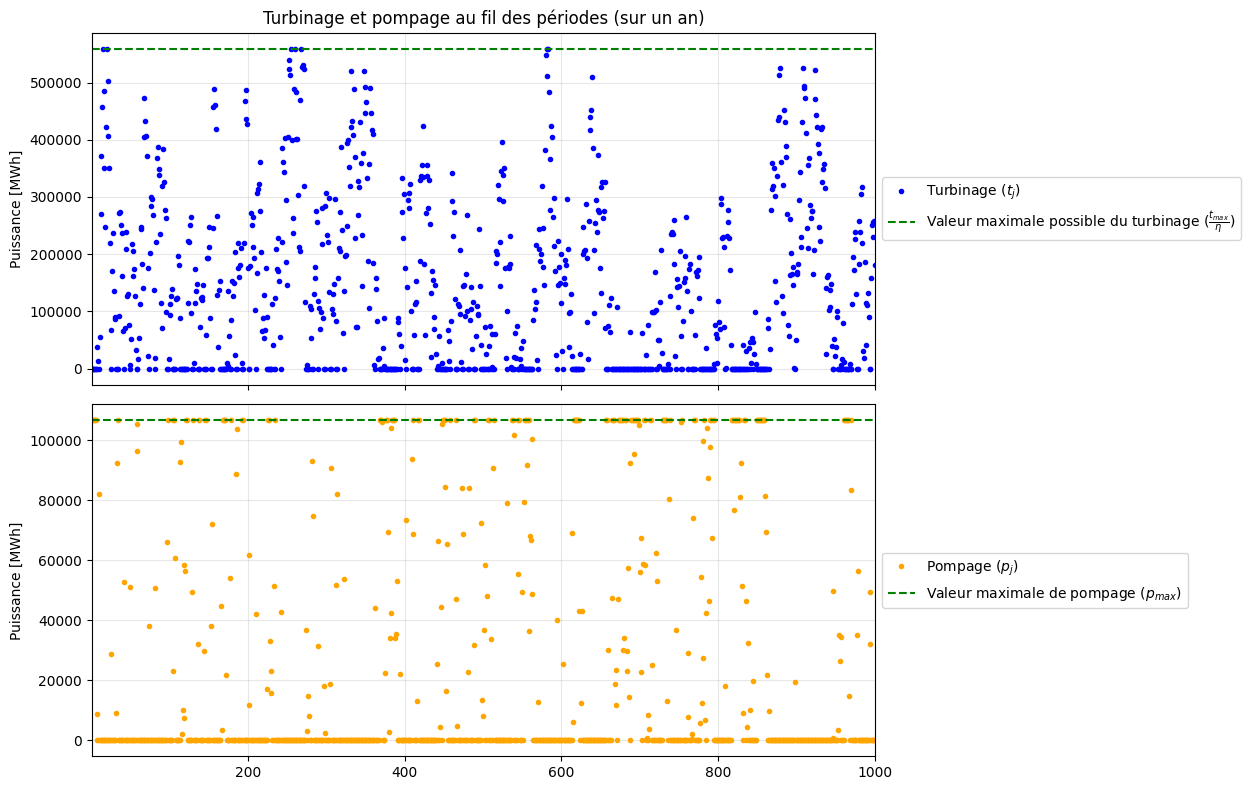

In [220]:
t = np.arange(1, m+1)

fig, axs = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

# Graphique pour Turbinage
axs[0].set_title('Turbinage et pompage au fil des périodes (sur un an)')
axs[0].plot(t, Turbinage, ".", label='Turbinage ($t_j$)', color='blue')
axs[0].set_ylabel('Puissance [MWh]')
axs[0].set_xlim(1, m)
axs[0].grid(alpha=0.3)
axs[0].axhline(y=max_turbine_power/0.85, color='g', linestyle='--', label='Valeur maximale possible du turbinage ($\\frac{t_{max}}{\\eta}$)')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Graphique pour Pompage
axs[1].plot(t, Pompage, ".", label='Pompage ($p_j$)', color='orange')
axs[0].set_xlim(1, m)
axs[1].set_ylabel('Puissance [MWh]')
axs[1].grid(alpha=0.3)
axs[1].axhline(y=max_pump_power, color='g', linestyle='--', label='Valeur maximale de pompage ($p_{max}$)')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.savefig('rapport/GraphesP2/Turbinage_pompage_Q5.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

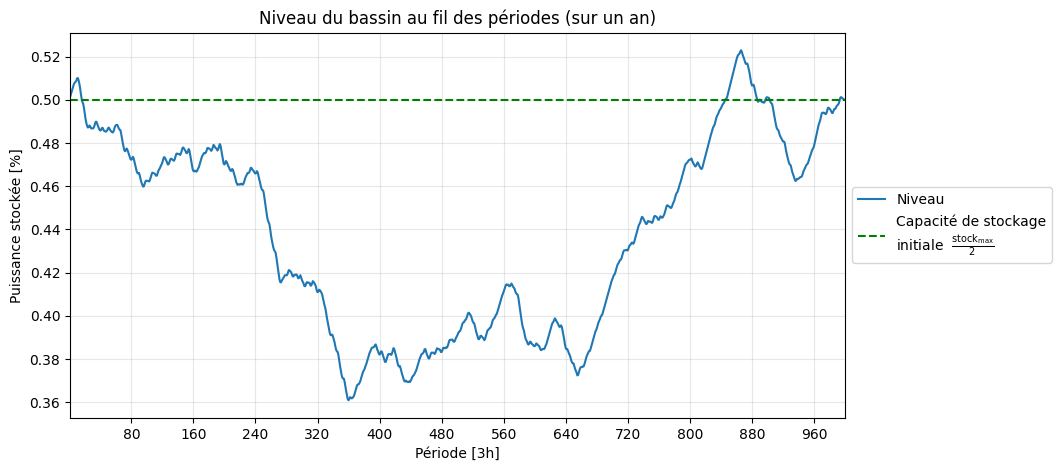

In [221]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Niveau du bassin au fil des périodes (sur un an)')
plt.plot(t, (max_stock/2 + np.tri(m)@Pompage - np.tri(m)@Turbinage + np.tri(m)@hydro_productions_3[0:m])/max_stock, label='Niveau')
plt.xlabel('Période [3h]')
plt.ylabel('Puissance stockée [%]')
plt.xlim(1,m)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.axhline(y=0.5, color='g', linestyle='--', label='Capacité de stockage\n'  + r"initiale  $\frac{\mathrm{stock}_\mathrm{max}}{2}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Niveau_Bassin_Q5.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [222]:
c = np.load("solutions/sol5_C.npy")
ChoixCombinés = np.array(c)
ChoixCombinés *= 0.5
Unique, Compte = np.unique(ChoixCombinés, return_counts=True)

dict(zip(Unique, Compte))

{-0.0: 341, 0.5: 12, 1.0: 289}

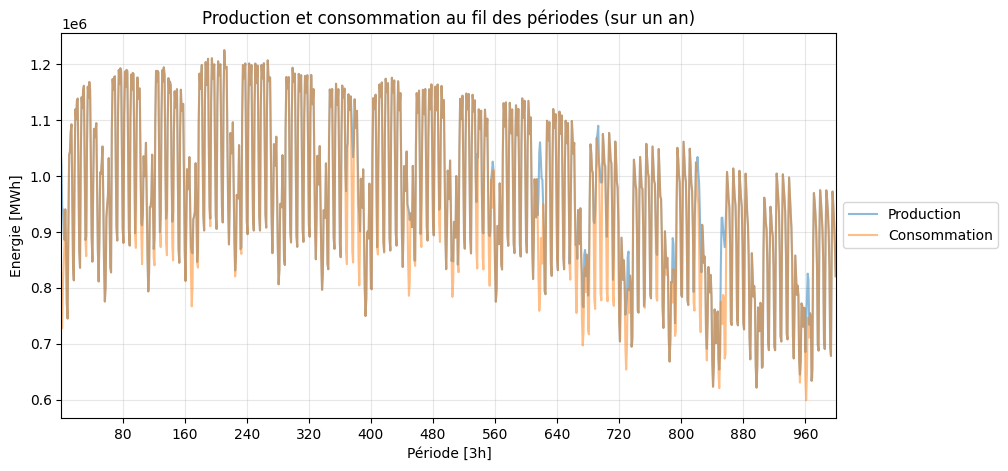

In [223]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Production et consommation au fil des périodes (sur un an)')
plt.plot((ChoixCombinés*max_capacity)@rendements_on_off_3[:,0:m] + 0.85*Turbinage - Pompage, label='Production', alpha = 0.5)
plt.plot(consumptions_3[0:m], label='Consommation', alpha = 0.5)
plt.xlabel('Période [3h]')
plt.ylabel('Energie [MWh]')
plt.xlim(1,m)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Prod_Cons_Q5.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Question 6

# Variables de décision
$$
\begin{align*} 
&c_i = \text{Capacité éolienne installée sur le site i} \quad \forall i \in \{0, \ldots, 641 \} \implies c \in \mathbb{R}^{642} \\
&t_j = \text{Puissance de turbinage à la période j} \quad \forall j \in \{0, \ldots, 2919\} \implies t \in \mathbb{R}^{2920}\\
&p_j = \text{Puissance de pompage à la période j} \quad \forall j \in \{0, \ldots, 2919 \} \implies p \in \mathbb{R}^{2920}\\
&g_j = \text{Energie produite par centrale au gaz à la période j} \quad \forall j \in \{0, \ldots, 2919 \} \implies g \in \mathbb{R}^{2920}\\
&g_{\mathrm{tot}} = \text{Puissance totale à installer pour les centrales au gaz} \implies g_{\mathrm{tot}} \in \mathbb{R}
\end{align*}
$$
# Problème à résoudre
$$
\begin{align*}
\min_{c, t, p, g, g_{\mathrm{tot}}} \mathrm{offshore\_cost}\times \sum_{offshore} c_i + \mathrm{onshore\_cost}\times \sum_{onshore} c_i &+ \mathrm{gaz\_prod\_cost}\times \sum_{j = 0}^{m-1}g_j + \mathrm{gaz\_install\_cost}\times 
g_\mathrm{tot}\\
\text{tel que} \\
\text{(Capacité éolienne entre 0 et son max)} \quad &0 \leq c_i \leq c_i^{max}  \quad \forall i \in \{0, \ldots, 641 \} \\
\text{(Le besoin de consommation est satisfait)} \quad &\sum_{i = 0}^{n-1} c_i e_i(j) + g_j + \eta *t_j - p_j \geq cons_j \quad \forall j \in \{0, \ldots, m-1\} \\
\text{(Physique du bassin, de base à 0.5 de capacité tot au début de la première période)} \quad & 0 \leq \frac{max\_stock}{2} + \sum_{i = 0}^{j} \left(p_i - t_i + a_i \right) \leq max\_stock \quad \forall j \in \{0, \ldots, m-2\} \\
\text{(Contrainte de bilan nul du bassin)} \quad &\sum_{i = 0}^{m-1} p_i - t_i + a_i = 0 \\
\text{(Contrainte de turbinage)} \quad &0 \leq \eta \cdot t_j \leq max\_turbinage \quad \forall j \in \{0, \ldots, m-1\} \\
\text{(Contrainte de pompage)} \quad &0 \leq p_j \leq max\_pompage \quad \forall j \in \{0, \ldots, m-1\}\\
\text{(Contrainte de production de gaz max)} \quad &0 \le g_j \le g_\mathrm{tot} \quad \forall j \in \{ 0, \ldots, m - 1\}
\end{align*}
$$

In [229]:
m = 2920

In [230]:
# Variable vectors
c = cp.Variable(n)
t = cp.Variable(m)
p = cp.Variable(m)
g_tot = cp.Variable(1)
g = cp.Variable(m)

# Objective function
costs = np.zeros(n)
costs[onshore_idx] = onshore_install_cost
costs[offshore_idx] = offshore_install_cost
f = cp.Minimize(costs.T@c + gaz_install_cost*g_tot + gaz_production_cost*np.ones(m)@g)

constraints = [
    c >= 0,
    c <= max_capacity,
    c@rendements_on_off_3[:, 0:m] + g + 0.85*t - p >= consumptions_3[0:m],
    0.5*max_stock + np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] <= max_stock,
    0.5*max_stock + np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] >= 0,
    np.ones(m)@p - np.ones(m)@t + np.ones(m)@hydro_productions_3[0:m] == 0,
    p >= 0,
    p <= max_pump_power,
    0.85*t >= 0,
    0.85*t <= max_turbine_power,
    g >= 0,
    g - g_tot <= 0,
]
problem = cp.Problem(f, constraints)

problem.solve(solver=cp.SCIPY, verbose=True)


                                     CVXPY                                     
                                     v1.5.0                                    
(CVXPY) May 14 04:06:38 PM: Your problem has 9403 variables, 27563 constraints, and 0 parameters.
(CVXPY) May 14 04:06:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 14 04:06:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 14 04:06:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 14 04:06:38 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 14 04:06:38 PM: Compiling problem (target solver=SCIPY

124718416283.98535

In [231]:
# Save the solution
dic = {
    'optimum': problem.value,
    'c': c.value.tolist(),
    't': t.value.tolist(),
    'p': p.value.tolist(),
    'g': g.value.tolist(),
    'g_tot': g_tot.value.tolist()
}

json_object = json.dumps(dic, indent = 4)

with open('solutions/sol6_All.json', 'w') as f:
    f.write(json_object)

In [236]:
sols = json.load(open('solutions/sol6_All.json'))
CoutTotal = sols["optimum"]
CoutTotal/ np.sum(consumptions_3) #€/MWh

48.15053852875043

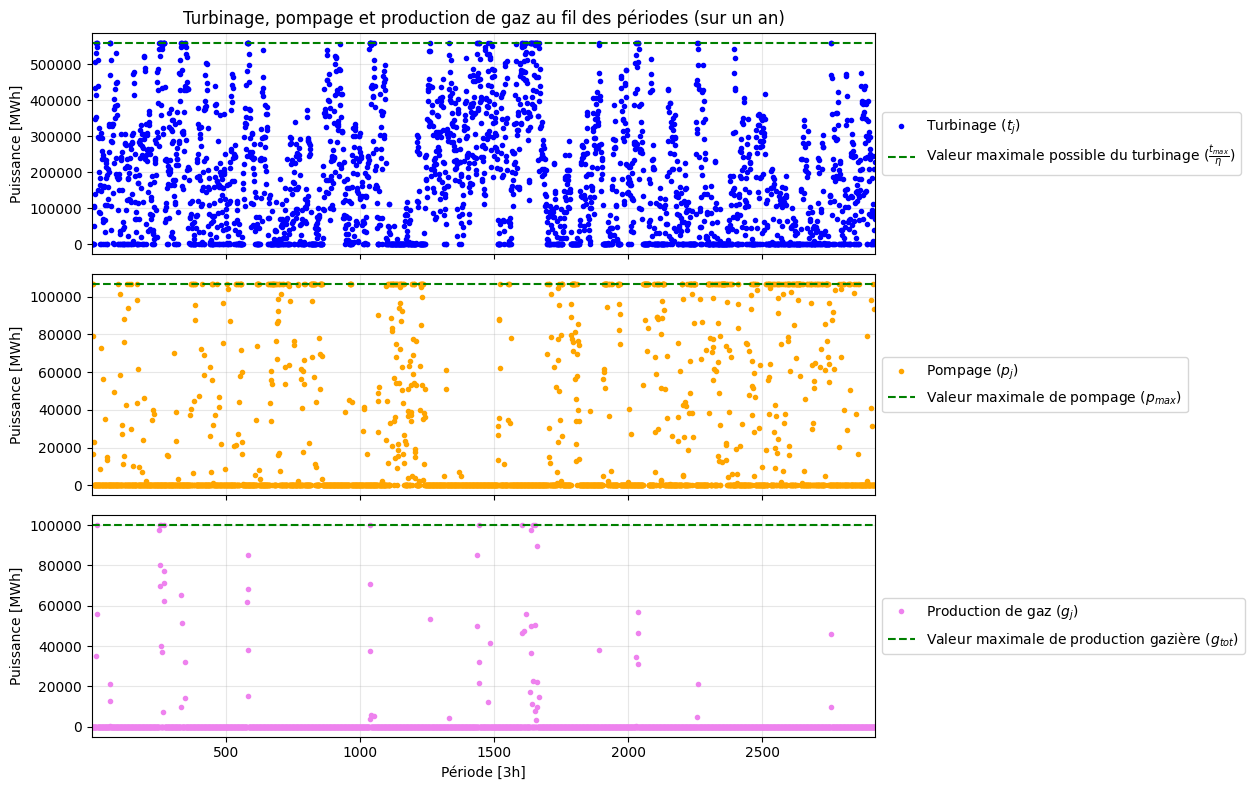

In [232]:
from matplotlib.ticker import MaxNLocator

Turbinage = np.array(sols['t'])
Pompage = np.array(sols['p'])
Gaz = np.array(sols['g'])
Gaz_tot = sols['g_tot'][0]
c = np.array(sols['c'])

# Générer les périodes
t = np.arange(1, m+1)

# Créer la figure et les axes pour les trois graphiques
fig, axs = plt.subplots(3, 1, figsize=(11, 8), sharex=True)

# Graphique pour Turbinage
axs[0].set_title('Turbinage, pompage et production de gaz au fil des périodes (sur un an)')
axs[0].plot(t, Turbinage, ".", label='Turbinage ($t_j$)', color='blue')
axs[0].set_ylabel('Puissance [MWh]')
axs[0].set_xlim(1, 2920)
axs[0].grid(alpha=0.3)
axs[0].axhline(y=max_turbine_power/0.85, color='g', linestyle='--', label='Valeur maximale possible du turbinage ($\\frac{t_{max}}{\\eta}$)')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Graphique pour Pompage
axs[1].plot(t, Pompage, ".", label='Pompage ($p_j$)', color='orange')
axs[1].set_ylabel('Puissance [MWh]')
axs[1].grid(alpha=0.3)
axs[1].axhline(y=max_pump_power, color='g', linestyle='--', label='Valeur maximale de pompage ($p_{max}$)')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Graphique pour Production de Gaz
axs[2].plot(t, Gaz,".", label='Production de gaz ($g_j$)', color='violet')
axs[2].set_xlabel('Période [3h]')
axs[2].set_ylabel('Puissance [MWh]')
axs[2].grid(alpha=0.3)
axs[2].axhline(y=Gaz_tot, color='g', linestyle='--', label='Valeur maximale de production gazière ($g_{tot}$)')
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Ajuster le placement des légendes
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.savefig('rapport/GraphesP2/Productions_Q6.pdf', format='pdf', bbox_inches='tight', pad_inches=0)


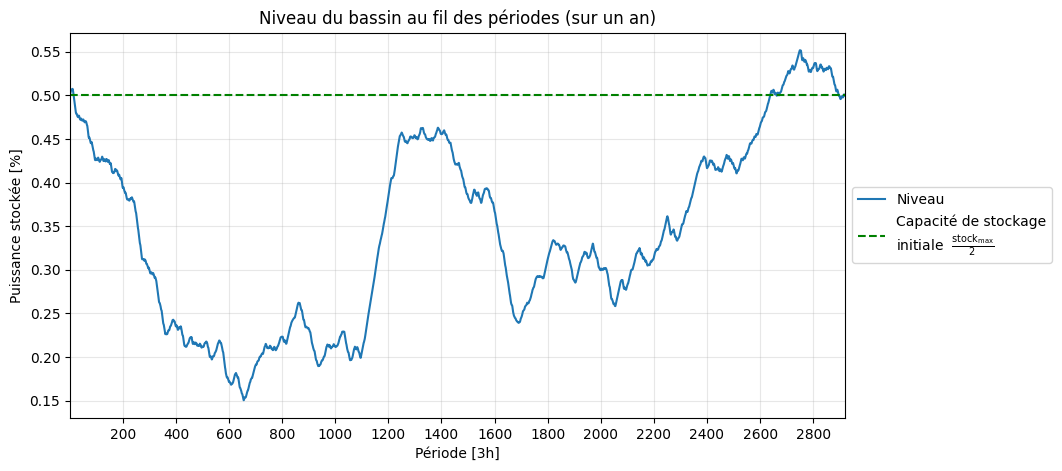

In [233]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Niveau du bassin au fil des périodes (sur un an)')
plt.plot(t, (max_stock/2 + np.tri(m)@Pompage - np.tri(m)@Turbinage + np.tri(m)@hydro_productions_3[0:m])/max_stock, label='Niveau')
plt.xlabel('Période [3h]')
plt.ylabel('Puissance stockée [%]')
plt.xlim(1,m)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.axhline(y=0.5, color='g', linestyle='--', label='Capacité de stockage\n'  + r"initiale  $\frac{\mathrm{stock}_\mathrm{max}}{2}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Niveau_Bassin_Q6.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

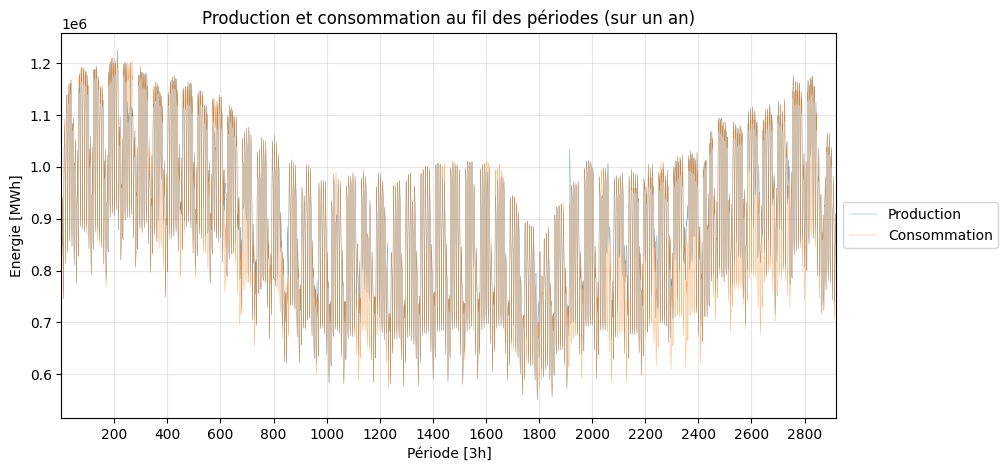

In [234]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Production et consommation au fil des périodes (sur un an)')
plt.plot(c@rendements_on_off_3 + 0.85*Turbinage - Pompage, label='Production', linewidth = 0.2)
plt.plot(consumptions_3, label='Consommation', linewidth = 0.2)
plt.xlabel('Période [3h]')
plt.ylabel('Energie [MWh]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Prod_Cons_Q6.pdf', format='pdf', bbox_inches='tight', pad_inches=0)